---
# 0. - Imports and paths

In [ ]:
import os
import pandas as pd
import matplotlib.font_manager as fm
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from PIL import Image, ImageDraw
import math 
import numpy as np
import re
from collections import defaultdict

In [ ]:
# Fetch DM Sans font file from https://github.com/google/fonts/blob/main/ofl/dmsans/DMSans%5Bopsz%2Cwght%5D.ttf or, better, https://fonts.google.com/specimen/DM+Sans
font_path = "../fonts/static/DMSans-Medium.ttf" 

# Add font to matplotlib
try:
    fm.fontManager.addfont(font_path)
    plt.rcParams['font.family'] = 'DM Sans'
except RuntimeError as e:
    print(f"Failed to load font: {e}")

# sns.set_theme(font_scale=1.5, style="whitegrid")
# biomodal_palette = ["#9CDBD9", "#C0DF16","#003B49","#05868E", "#ABAD9A", "#F87C56","#00DAEF","#50B37B"]
# sns.set_palette(biomodal_palette)

In [ ]:
# # Test plot
# plt.figure(figsize=(6, 4))
# plt.title("Test Plot with DM Sans Font μ", fontsize=16)
# plt.plot([1, 2, 3], [4, 6, 8])
# plt.show()

In [ ]:
os.chdir("/disk2/user/gabgam/work/gigi_env/the_project/4_clustering_and_classification/")
print(os.getcwd())

/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification


In [ ]:
model = "kimianet"

In [ ]:
PATH_TO_SAVED_FEATURES = f"../3_features_extraction/output/{model}/satac_C1_v3_allspots_&_visium_2022_FF_WG_10X_img_not_changed_allspots/" # must end with "/"

In [ ]:
if PATH_TO_SAVED_FEATURES.endswith("/"):
    path_to_paired_pickles = f"output/{model}/{PATH_TO_SAVED_FEATURES.split('/')[-2]}/"
    print(path_to_paired_pickles)
else:
    print("Adapt the path string to the correct format (must ends with \"/\").")

os.makedirs(path_to_paired_pickles, exist_ok=True)

output/kimianet/satac_C1_v3_allspots_&_visium_2022_FF_WG_10X_img_not_changed_allspots/


In [ ]:
# path to the target image
PATH_TO_REFERENCE = "../2_image_normalisation/reference_images/reference_full.jpeg"
# `TARGET_IS_<filename>`
TARGET_IS = "target_is_reference_full"

Defining some functions.

In [ ]:
# Function to load a pickle file as a DataFrame
def load_pickle_as_df(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)  # Pandas DataFrame


# ---------------------------------------------------------------
# Function to save the merged DataFrame as a pickle file
def save_pickle(df, output_path):
    with open(output_path, 'wb') as f:
        pickle.dump(df, f)

# 1. - Importing the extracted features

First of all, let's see all the `.pickle` files inside the folder of the saved features.

In [ ]:
all_pickles = [i for i in os.listdir(PATH_TO_SAVED_FEATURES) if i.endswith(".pickle")]

print(f"{len(all_pickles)} .pickle files inside the folder.\n")
print(all_pickles)

16 .pickle files inside the folder.

['satac_C1_&_v3_allspots_&_target_is_reference_full_100um_ORIGINAL WSI.pickle', 'satac_C1_&_v3_allspots_&_target_is_reference_full_100um_fromWSI_histomicsTK_macenko_nomasking.pickle', 'satac_C1_&_v3_allspots_&_target_is_reference_full_100um_histomicsTK_macenko_nomasking.pickle', 'satac_C1_&_v3_allspots_&_target_is_reference_full_100um_stainNET.pickle', 'satac_C1_&_v3_allspots_&_target_is_reference_full_68um_ORIGINAL WSI.pickle', 'satac_C1_&_v3_allspots_&_target_is_reference_full_68um_fromWSI_histomicsTK_macenko_nomasking.pickle', 'satac_C1_&_v3_allspots_&_target_is_reference_full_68um_histomicsTK_macenko_nomasking.pickle', 'satac_C1_&_v3_allspots_&_target_is_reference_full_68um_stainNET.pickle', 'visium_2022_FF_WG_10X_&_img_not_changed_allspots_&_target_is_reference_full_100um_ORIGINAL WSI.pickle', 'visium_2022_FF_WG_10X_&_img_not_changed_allspots_&_target_is_reference_full_100um_fromWSI_histomicsTK_macenko_nomasking.pickle', 'visium_2022_FF_WG_10X_

In [ ]:
# # Dictionary to store files by category
# grouped_files = defaultdict(dict)

# # Regular expression to extract tile size and normalization method
# pattern = re.compile(r'(satac|visium).*?_(\d+um)_(.*)\.pickle')

# for file in all_pickles:
#     match = pattern.search(file)
#     if match:
#         dataset, tile_size, method = match.groups()
#         grouped_files[(tile_size, method)][dataset] = file

# # Create pairs
# paired_pickles = [
#     (group['satac'], group['visium'])
#     for key, group in grouped_files.items()
#     if 'satac' in group and 'visium' in group
# ]

# paired_pickles

In [ ]:
# Dictionary to store files by (tile size, normalization method, target name)
grouped_files = defaultdict(dict)

# Regular expression to extract dataset, tile size, normalization method, and ensure the target name is "target_is_reference_full"
pattern = re.compile(rf'(satac|visium).*?_{TARGET_IS}_(\d+um)_(.*)\.pickle')

for file in all_pickles:
    match = pattern.search(file)
    if match:
        dataset, tile_size, method = match.groups()
        grouped_files[(tile_size, method)][dataset] = file


# Process and merge pairs
for (tile_size, method), group in grouped_files.items():
    if 'satac' in group and 'visium' in group:
        satac_file = group['satac']
        visium_file = group['visium']

        print(f"Processing pair:\nSATAC: {satac_file}\nVISIUM: {visium_file}\n")

        # Load both files as DataFrames and invert them before merging based on coloumns
        satac_df = load_pickle_as_df(os.path.join(PATH_TO_SAVED_FEATURES, satac_file)).T
        visium_df = load_pickle_as_df(os.path.join(PATH_TO_SAVED_FEATURES, visium_file)).T

        # Merge DataFrames (concatenation)
        merged_df = pd.concat([satac_df, visium_df], axis = 0)
        
        # Construct the merged filename
        satac_base = "_&_".join(os.path.splitext(satac_file)[0].split("_&_")[:2]) # extracting the satac name
        visium_base = "_&_".join(os.path.splitext(visium_file)[0].split("_&_")[:2]) # extracting the visium name
        normalisation_method = os.path.splitext(satac_file)[0].split("_&_")[-1] # extracting the target name and normalisation method
        
        merged_name = f"MERGED_{satac_base}__&__{visium_base}__for__{normalisation_method}.pickle"
        
        
        # Define output filename
        output_file = os.path.join(path_to_paired_pickles, merged_name)

        # Save the merged DataFrame
        save_pickle(merged_df, output_file)
        print(f"Saved merged file: {output_file}\n")

Processing pair:
SATAC: satac_C1_&_v3_allspots_&_target_is_reference_full_100um_ORIGINAL WSI.pickle
VISIUM: visium_2022_FF_WG_10X_&_img_not_changed_allspots_&_target_is_reference_full_100um_ORIGINAL WSI.pickle

Saved merged file: output/kimianet/satac_C1_v3_allspots_&_visium_2022_FF_WG_10X_img_not_changed_allspots/MERGED_satac_C1_&_v3_allspots__&__visium_2022_FF_WG_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_ORIGINAL WSI.pickle

Processing pair:
SATAC: satac_C1_&_v3_allspots_&_target_is_reference_full_100um_fromWSI_histomicsTK_macenko_nomasking.pickle
VISIUM: visium_2022_FF_WG_10X_&_img_not_changed_allspots_&_target_is_reference_full_100um_fromWSI_histomicsTK_macenko_nomasking.pickle

Saved merged file: output/kimianet/satac_C1_v3_allspots_&_visium_2022_FF_WG_10X_img_not_changed_allspots/MERGED_satac_C1_&_v3_allspots__&__visium_2022_FF_WG_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_fromWSI_histomicsTK_macenko_nomasking.pickle

Processing 

Let's visualise the names.

In [ ]:
print([i for i in os.listdir(path_to_paired_pickles)])

['MERGED_satac_C1_&_v3_allspots__&__visium_2022_FF_WG_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_ORIGINAL WSI.pickle', 'MERGED_satac_C1_&_v3_allspots__&__visium_2022_FF_WG_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_fromWSI_histomicsTK_macenko_nomasking.pickle', 'MERGED_satac_C1_&_v3_allspots__&__visium_2022_FF_WG_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_histomicsTK_macenko_nomasking.pickle', 'MERGED_satac_C1_&_v3_allspots__&__visium_2022_FF_WG_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_stainNET.pickle', 'MERGED_satac_C1_&_v3_allspots__&__visium_2022_FF_WG_10X_&_img_not_changed_allspots__for__target_is_reference_full_68um_ORIGINAL WSI.pickle', 'MERGED_satac_C1_&_v3_allspots__&__visium_2022_FF_WG_10X_&_img_not_changed_allspots__for__target_is_reference_full_68um_fromWSI_histomicsTK_macenko_nomasking.pickle', 'MERGED_satac_C1_&_v3_allspots__&__visium_2022_FF_WG_10X_&_img_not_changed_allsp

And let's choose the first file to visualise and extract the normalisation name from it.

In [ ]:
SELECTED_PICKLE = 'MERGED_satac_C1_&_v3_allspots__&__visium_2022_FF_WG_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_ORIGINAL WSI.pickle'

# Find the pattern matching "<number>um_", the normalisation name is after it.
match = re.search(r"\d+um_", SELECTED_PICKLE)

if match:
    # Extract everything after "<number>um_", remove the file type name and replace eventually present underscores with spaces.
    normalisation_name = SELECTED_PICKLE.split(match.group())[-1].split(".")[0].replace("_", " ")
else:
    print("Wrong file inserted, no normalisation name found.")

print(normalisation_name)

ORIGINAL WSI


In [ ]:
merged_selected_pickle_df = load_pickle_as_df(os.path.join(path_to_paired_pickles, SELECTED_PICKLE))
merged_selected_pickle_df

0         1         2         3     \
CCGACCACCCTACGCG_row0_col0_100um       0.059522  0.140928  0.247563 -0.508472   
AAGCCATAGTCGCGAC_row1_col1_100um       0.073656  0.145695  0.287638 -0.558940   
TTGGGCGGACCGAAGC_row0_col2_100um       0.069950  0.139424  0.250986 -0.561079   
AGTAAAGCGCATAATC_row1_col3_100um       0.075315  0.149537  0.253149 -0.534289   
CGACTCCGCCGATCAA_row0_col4_100um       0.070702  0.151160  0.211443 -0.539104   
...                                         ...       ...       ...       ...   
GAACGTTTGTATCCAC-1_row77_col123_100um  0.073706  0.197554  0.043509 -0.270558   
ATTGAATTCCCTGTAG-1_row76_col124_100um  0.055936  0.221513 -0.029116 -0.254872   
TACCTCACCAATTGTA-1_row77_col125_100um  0.063011  0.196832  0.040659 -0.304752   
AGTCGAATTAGCGTAA-1_row76_col126_100um  0.064607  0.188522 -0.007938 -0.271109   
TTGAAGTGCATCTACA-1_row77_col127_100um  0.061908  0.199866  0.050595 -0.315343   

                                           4         5         6         7     \
CCGACCACCCTACGCG_row0_col0_100um      -0.021711 -0.709956  0.060096  0.157893   
AAGCCATAGTCGCGAC_row1_col1_100um       0.096748 -1.176329  0.059493  0.158656   
TTGGGCGGACCGAAGC_row0_col2_100um       0.009842 -1.404229  0.057943  0.160122   
AGTAAAGCGCATAATC_row1_col3_100um       0.077689 -0.895622  0.057525  0.160333   
CGACTCCGCCGATCAA_row0_col4_100um       0.086946 -0.979487  0.053470  0.157835   
...                                         ...       ...       ...       ...   
GAACGTTTGTATCCAC-1_row77_col123_100um  0.048577 -0.382721  0.049047  0.151398   
ATTGAATTCCCTGTAG-1_row76_col124_100um  0.067334 -0.295562  0.026021  0.148289   
TACCTCACCAATTGTA-1_row77_col125_100um -0.028047 -0.351535  0.036285  0.151153   
AGTCGAATTAGCGTAA-1_row76_col126_100um  0.123820 -0.654719  0.030910  0.148786   
TTGAAGTGCATCTACA-1_row77_col127_100um  0.150009  0.102752  0.038671  0.151258   

                                           8         9     ...      1014  \
CCGACCACCCTACGCG_row0_col0_100um      -0.427116 -0.097706  ...  1.050702   
AAGCCATAGTCGCGAC_row1_col1_100um      -0.314060 -0.064176  ...  1.095269   
TTGGGCGGACCGAAGC_row0_col2_100um      -0.455113 -0.082831  ...  1.369773   
AGTAAAGCGCATAATC_row1_col3_100um      -0.472179 -0.109915  ...  1.139156   
CGACTCCGCCGATCAA_row0_col4_100um      -0.280461 -0.060657  ...  0.925112   
...                                         ...       ...  ...       ...   
GAACGTTTGTATCCAC-1_row77_col123_100um  0.946898  0.086465  ... -2.901534   
ATTGAATTCCCTGTAG-1_row76_col124_100um  0.804310  0.054170  ... -2.764123   
TACCTCACCAATTGTA-1_row77_col125_100um  0.637543  0.024027  ... -1.914221   
AGTCGAATTAGCGTAA-1_row76_col126_100um  0.767581  0.037605  ... -2.378068   
TTGAAGTGCATCTACA-1_row77_col127_100um  0.565587  0.084846  ... -4.322037   

                                           1015      1016      1017      1018  \
CCGACCACCCTACGCG_row0_col0_100um       1.247908  1.165411  0.971441  0.339985   
AAGCCATAGTCGCGAC_row1_col1_100um       1.291945  1.103361  0.222980 -0.134149   
TTGGGCGGACCGAAGC_row0_col2_100um       0.933314  1.253994  0.680394  0.113496   
AGTAAAGCGCATAATC_row1_col3_100um       1.037374  1.287935  0.812133 -0.186206   
CGACTCCGCCGATCAA_row0_col4_100um       1.046438  0.996681  0.729117  0.196370   
...                                         ...       ...       ...       ...   
GAACGTTTGTATCCAC-1_row77_col123_100um  5.206633 -0.146404  1.651293 -1.745891   
ATTGAATTCCCTGTAG-1_row76_col124_100um  2.808252  0.160836 -0.488469 -2.798326   
TACCTCACCAATTGTA-1_row77_col125_100um  4.003174 -0.888989 -2.300997  0.104985   
AGTCGAATTAGCGTAA-1_row76_col126_100um  1.876357  1.755340 -0.820926 -1.579421   
TTGAAGTGCATCTACA-1_row77_col127_100um  4.155913 -0.355115  0.998661 -2.572890   

                                           1019      1020      1021      1022  \
CCGACCACCCTACGCG_row0_col0_100um       0.552320  1.137402  0.320085  1.293354   
AAGCCATAGTCGCGAC_row1_col1_100um       0.944193  

# 2. Dimensionality reduction

/disk2/user/gabgam/miniconda3/envs/kimianet_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_2362255/50980120.py:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors_wenwen, s=4, cmap='Spectral')
/disk2/user/gabgam/miniconda3/envs/kimianet_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_2362255/50980120.py:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors_wenwen, s=4, cmap='Spectral')
/tmp/ipykernel_2362255/50980120.py:28: UserWarning: No data for colormapping pr

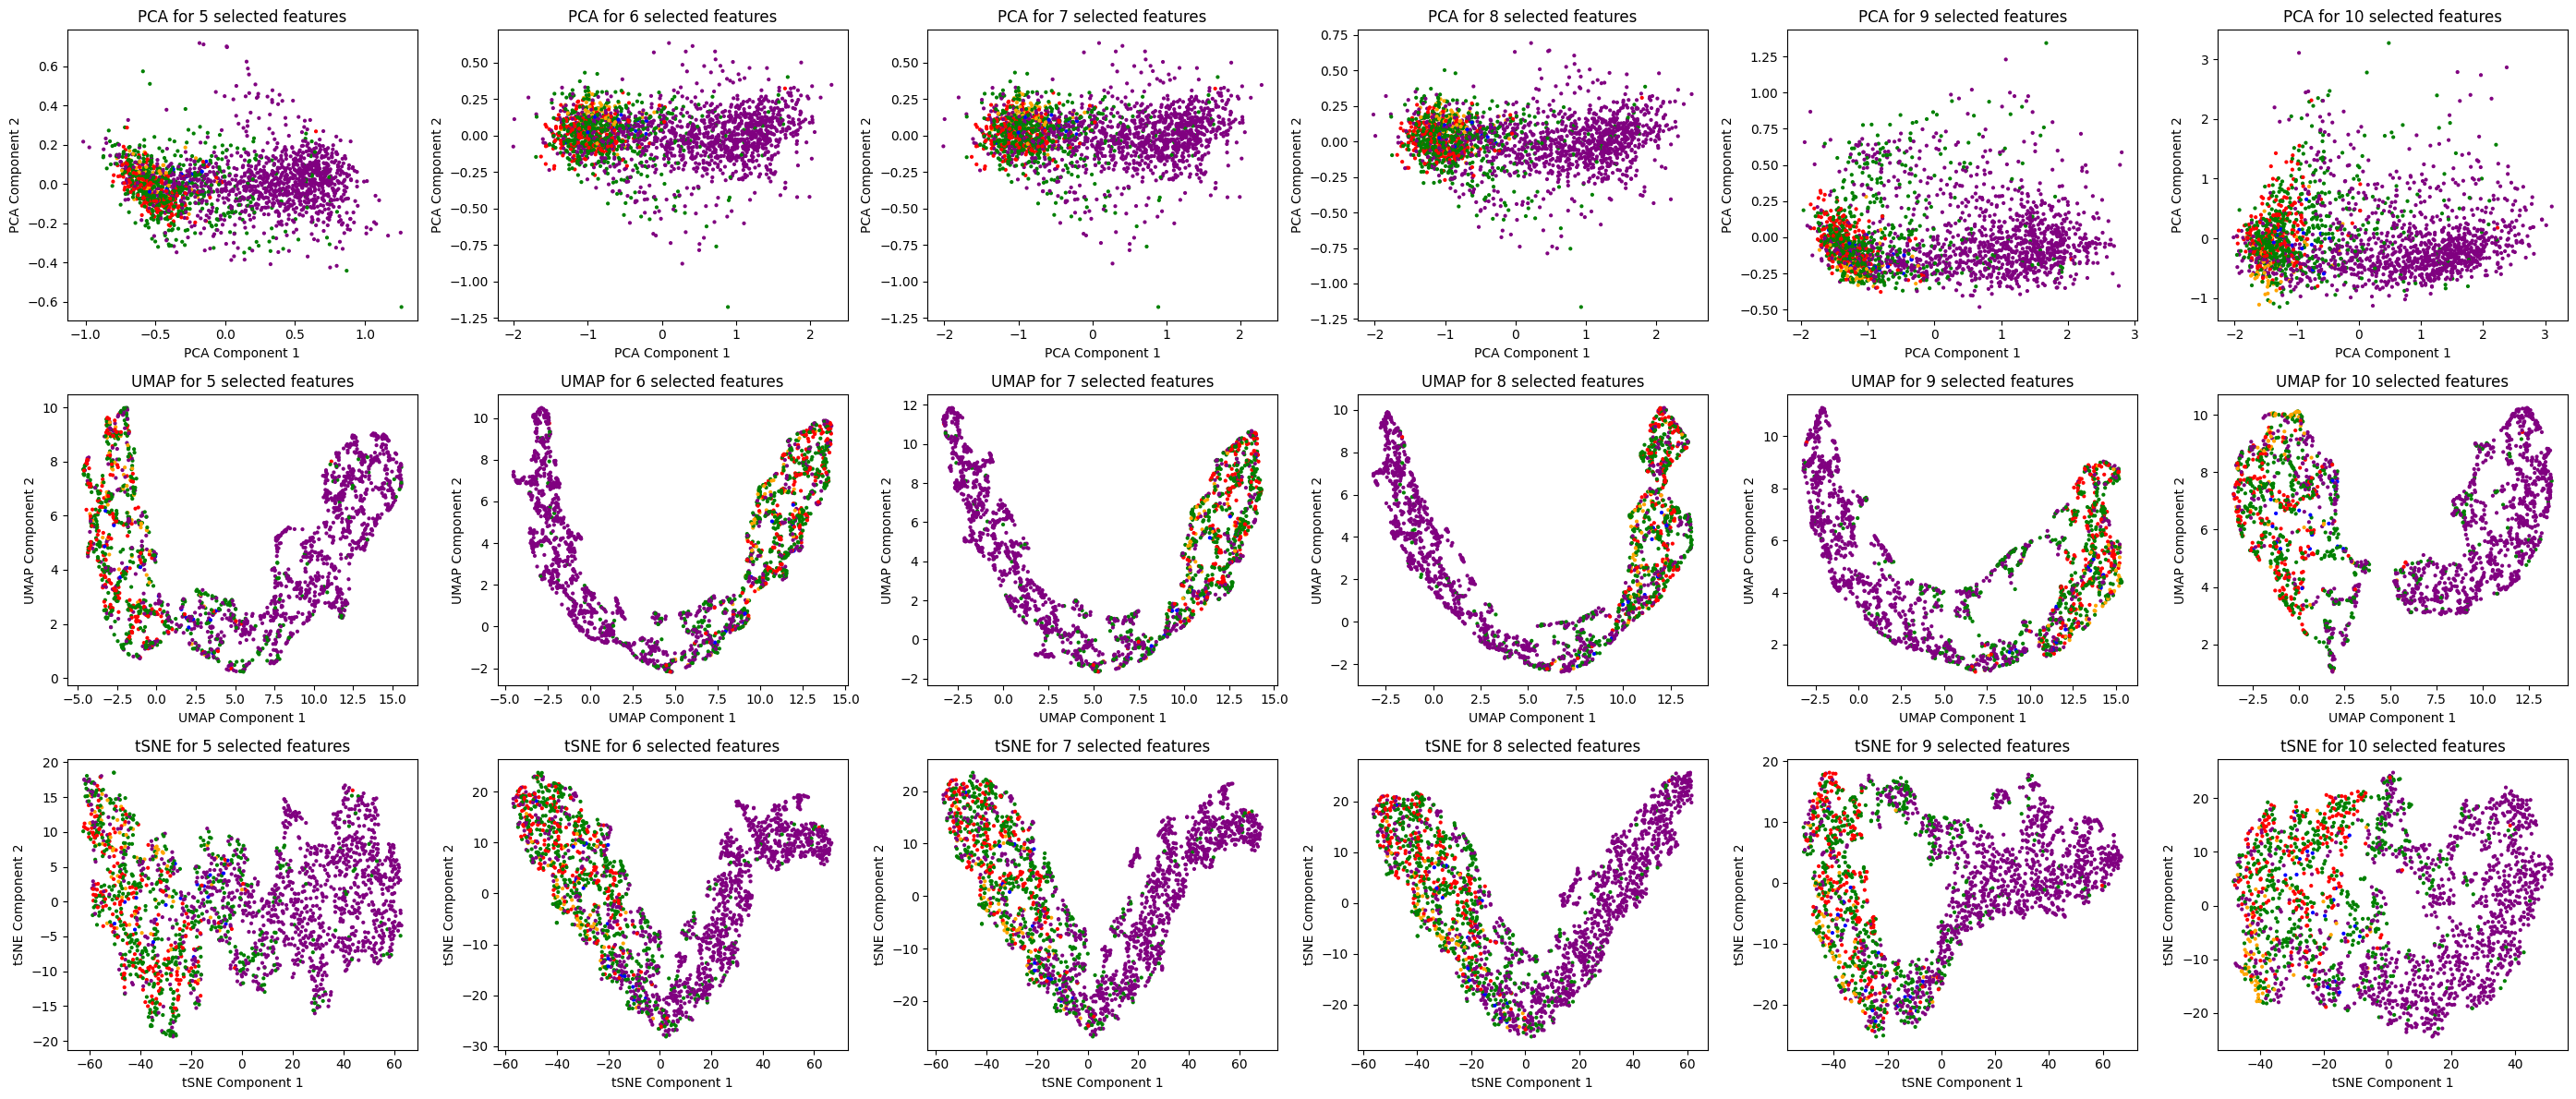

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import FeatureAgglomeration
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE

# Initialize a figure to organize subplots for 18 plots (3 rows for PCA, UMAP, tSNE; 6 columns for cluster counts)
fig, axes = plt.subplots(3, 6, figsize=(28, 12))  # Adjusted size for better spacing
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Define a list of models and a dictionary for storing colors
models = [("PCA", PCA(n_components=2)), 
          ("UMAP", umap.UMAP(n_components=2, random_state=123)),
          ("tSNE", TSNE(n_components=2, perplexity=50, random_state=123))]

# FeatureAgglomeration and dimensionality reduction
for n in range(5, 11):
    # Step 1: Feature Agglomeration
    feat_aggr = FeatureAgglomeration(n_clusters=n, metric='euclidean', linkage='ward')
    feat_aggr_result = feat_aggr.fit_transform(annotated_features[:, 1:])
    
    # Step 2: Dimensionality Reduction and Plotting
    for i, (method_name, model) in enumerate(models):
        result = model.fit_transform(feat_aggr_result)
        
        # Plot the reduced result in a subplot
        ax = axes[i * 6 + (n - 5)]  # Adjust subplot index for each method and cluster count
        scatter = ax.scatter(result[:, 0], result[:, 1], c=colors_wenwen, s=4, cmap='Spectral')
        ax.set_title(f"{method_name} for {n} selected features")
        ax.set_xlabel(f'{method_name} Component 1')
        ax.set_ylabel(f'{method_name} Component 2')

# Add colorbar for all scatter plots
#fig.colorbar(scatter, ax=axes, orientation="horizontal", pad=0.01)
plt.tight_layout()
plt.show()


Original feature shape: (2061, 1024)
Reduced feature shape with n_clusters=25: (2061, 25)


/disk2/user/gabgam/miniconda3/envs/kimianet_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Original feature shape: (2061, 1024)
Reduced feature shape with n_clusters=50: (2061, 50)


/disk2/user/gabgam/miniconda3/envs/kimianet_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Original feature shape: (2061, 1024)
Reduced feature shape with n_clusters=75: (2061, 75)


/disk2/user/gabgam/miniconda3/envs/kimianet_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Original feature shape: (2061, 1024)
Reduced feature shape with n_clusters=100: (2061, 100)


/disk2/user/gabgam/miniconda3/envs/kimianet_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Original feature shape: (2061, 1024)
Reduced feature shape with n_clusters=200: (2061, 200)


/disk2/user/gabgam/miniconda3/envs/kimianet_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Original feature shape: (2061, 1024)
Reduced feature shape with n_clusters=400: (2061, 400)


/disk2/user/gabgam/miniconda3/envs/kimianet_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


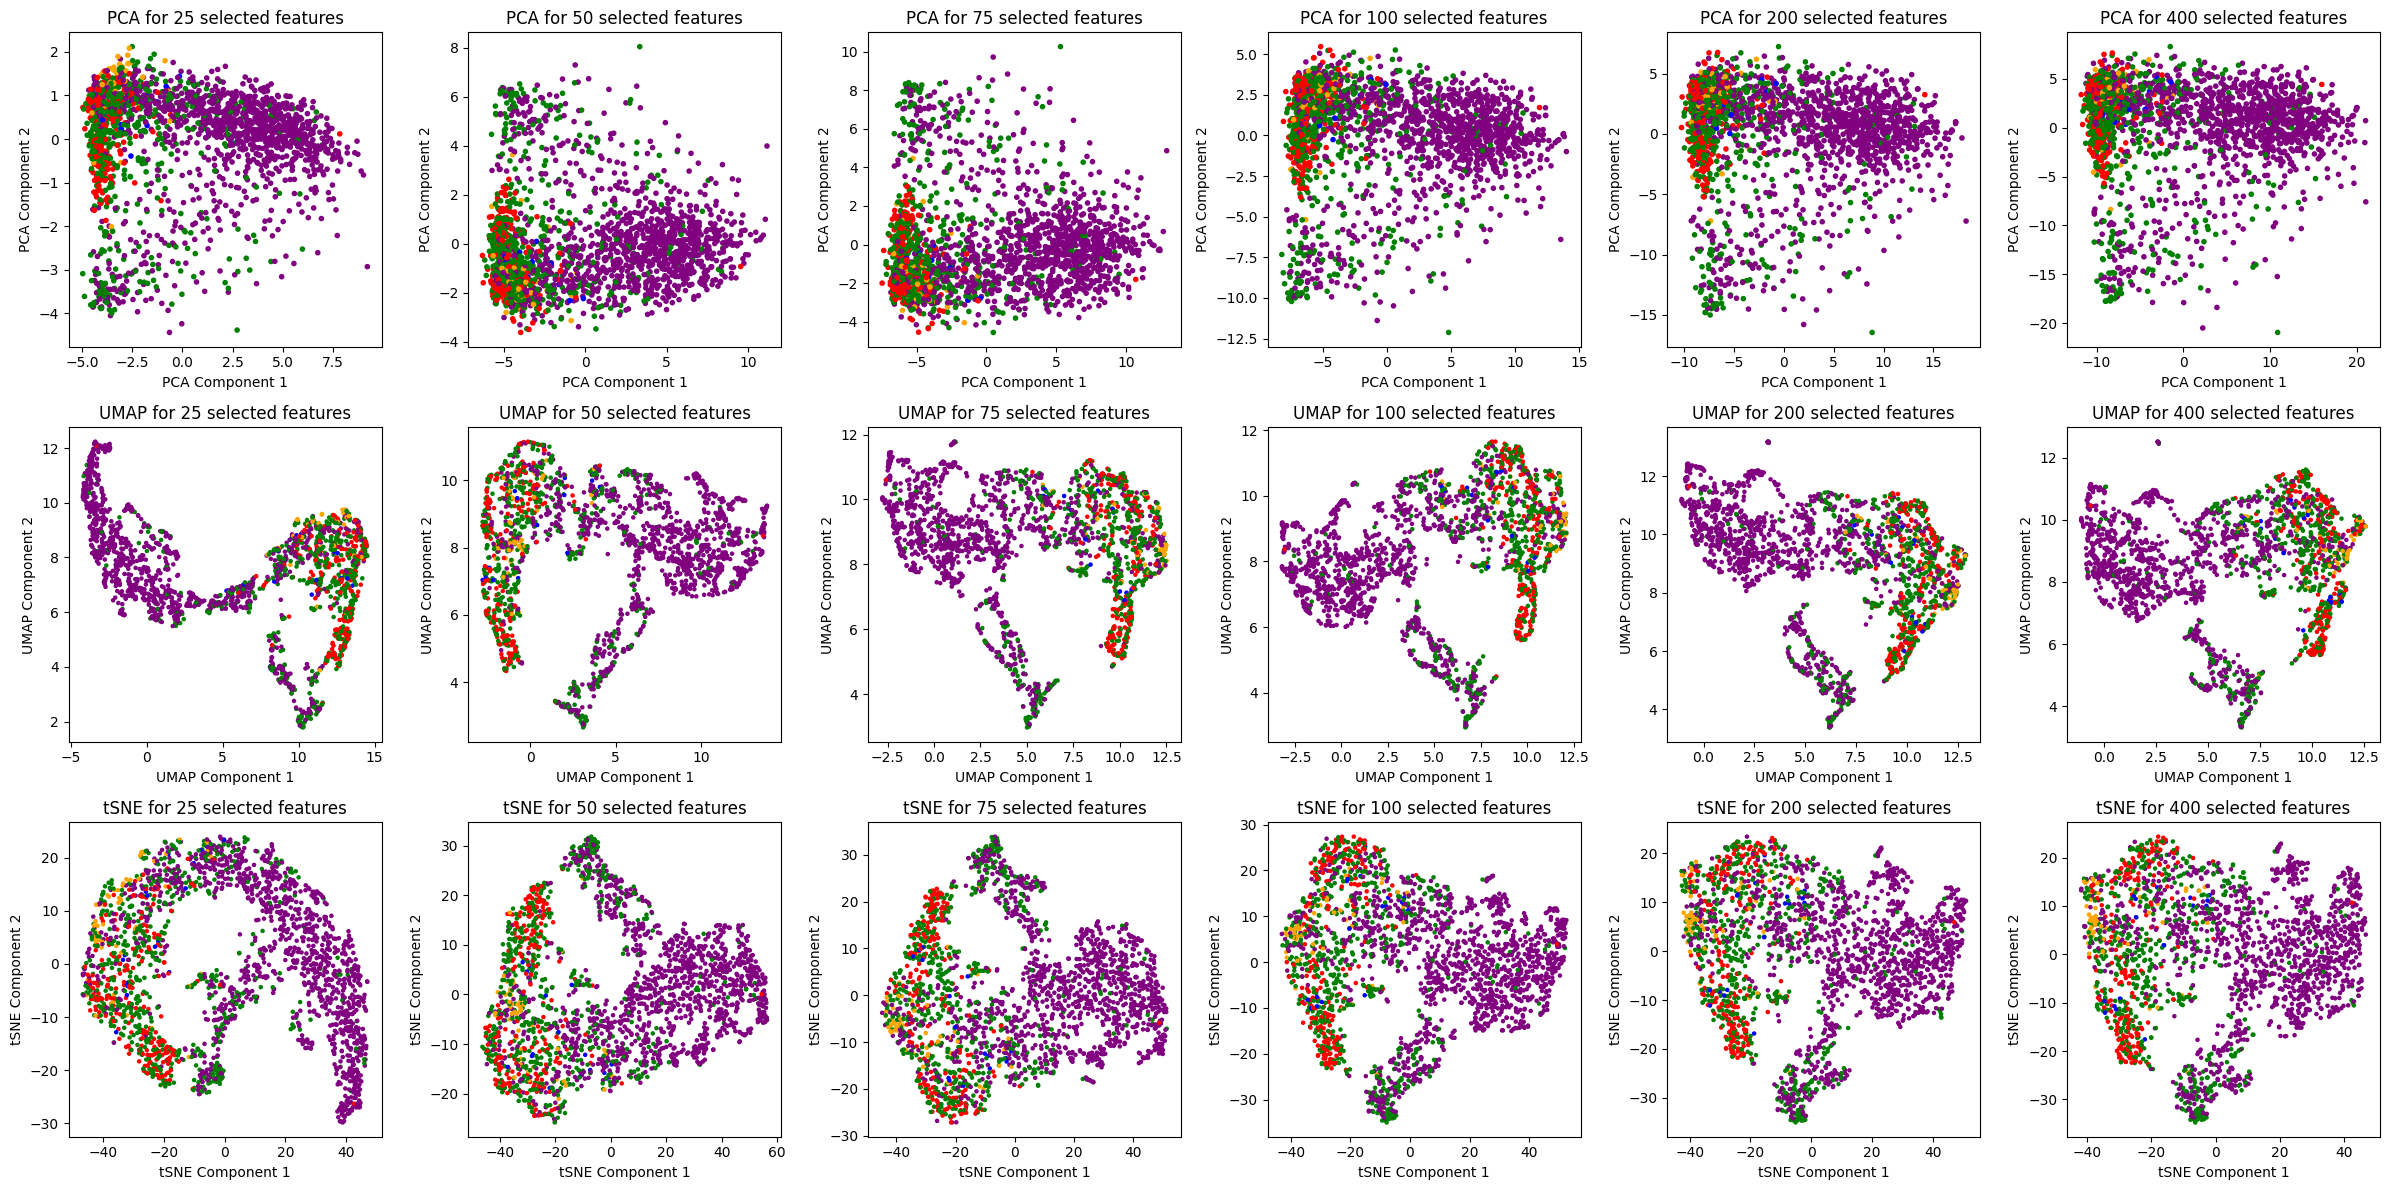

In [ ]:
from sklearn.cluster import FeatureAgglomeration
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt

# Define the list of clusters to try
cluster_list = [25, 50, 75, 100, 200, 400]

# Set up a large grid for subplots to hold all visualizations
fig, axes = plt.subplots(3, len(cluster_list), figsize=(4 * len(cluster_list), 12))

for i, n in enumerate(cluster_list):
    # Perform FeatureAgglomeration with the specified number of clusters
    feat_aggre_model = FeatureAgglomeration(n_clusters=n, metric='euclidean', linkage='ward')
    feat_aggr_result = feat_aggre_model.fit_transform(annotated_features[:, 1:])

    print(f"Original feature shape: {annotated_features[:, 1:].shape}")
    print(f"Reduced feature shape with n_clusters={n}: {feat_aggr_result.shape}")

    # Perform PCA for visualization
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(feat_aggr_result)
    ax = axes[0, i]
    ax.scatter(pca_result[:, 0], pca_result[:, 1], marker='.', c=colors_wenwen)
    ax.set_title(f'PCA for {n} selected features')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')

    # Perform UMAP for visualization
    umap_model = umap.UMAP(n_components=2, random_state=123)
    umap_result = umap_model.fit_transform(feat_aggr_result)
    ax = axes[1, i]
    ax.scatter(umap_result[:, 0], umap_result[:, 1], s=5, c=colors_wenwen)
    ax.set_title(f'UMAP for {n} selected features')
    ax.set_xlabel('UMAP Component 1')
    ax.set_ylabel('UMAP Component 2')

    # Perform t-SNE for visualization
    tsne_model = TSNE(n_components=2, perplexity=50, random_state=123)
    tsne_result = tsne_model.fit_transform(feat_aggr_result)
    ax = axes[2, i]
    ax.scatter(tsne_result[:, 0], tsne_result[:, 1], s=5, c=colors_wenwen)
    ax.set_title(f'tSNE for {n} selected features')
    ax.set_xlabel('tSNE Component 1')
    ax.set_ylabel('tSNE Component 2')

plt.tight_layout()
plt.show()


## 3.1 Principal Component Analysis (PCA)


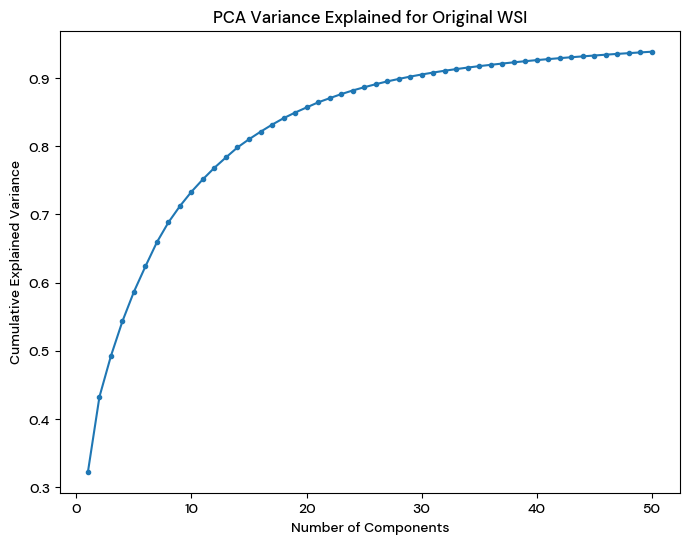

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming 'annotated_features' is your 2353 x 1024 matrix
pca = PCA(n_components=50)  # Reduce to 50 components for further analysis
pca_components = pca.fit_transform(merged_selected_pickle_df)

# Optional: Visualize variance explained by each principal component
plt.figure(figsize=(8, 6))
plt.plot(range(1, 51), pca.explained_variance_ratio_.cumsum(), marker='.')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title(f'PCA Variance Explained for {NORMALISATION_NAME}')
plt.show()


In [ ]:
pca_components

array([[ 1.6008030e+01,  4.9313807e+00, -2.0085433e+00, ...,
        -9.6562535e-01, -9.1689253e-01,  5.8001070e-03],
       [ 1.7968372e+01,  1.3585889e+00, -3.5074012e+00, ...,
        -1.3029082e+00,  7.5996816e-01,  5.4590851e-01],
       [ 1.7179184e+01,  2.5746000e+00, -2.4328315e+00, ...,
        -5.7872546e-01,  2.7389884e-01, -1.1600260e-01],
       ...,
       [-1.3679839e+01,  6.1409335e+00,  5.6908865e+00, ...,
        -1.3353469e+00,  5.1675528e-01, -7.2607213e-01],
       [-2.0389616e+01,  7.1148357e+00,  6.8300619e+00, ...,
        -3.9812717e-01, -1.4196777e+00, -2.8555563e-01],
       [-2.3998707e+01,  1.7605532e+00,  3.5610153e+01, ...,
        -9.5658219e-01, -8.8093871e-01, -5.3812195e-02]], dtype=float32)

/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_3947152/1963932358.py:36: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_3947152/1963932358.py:36: UserWarning: No data f

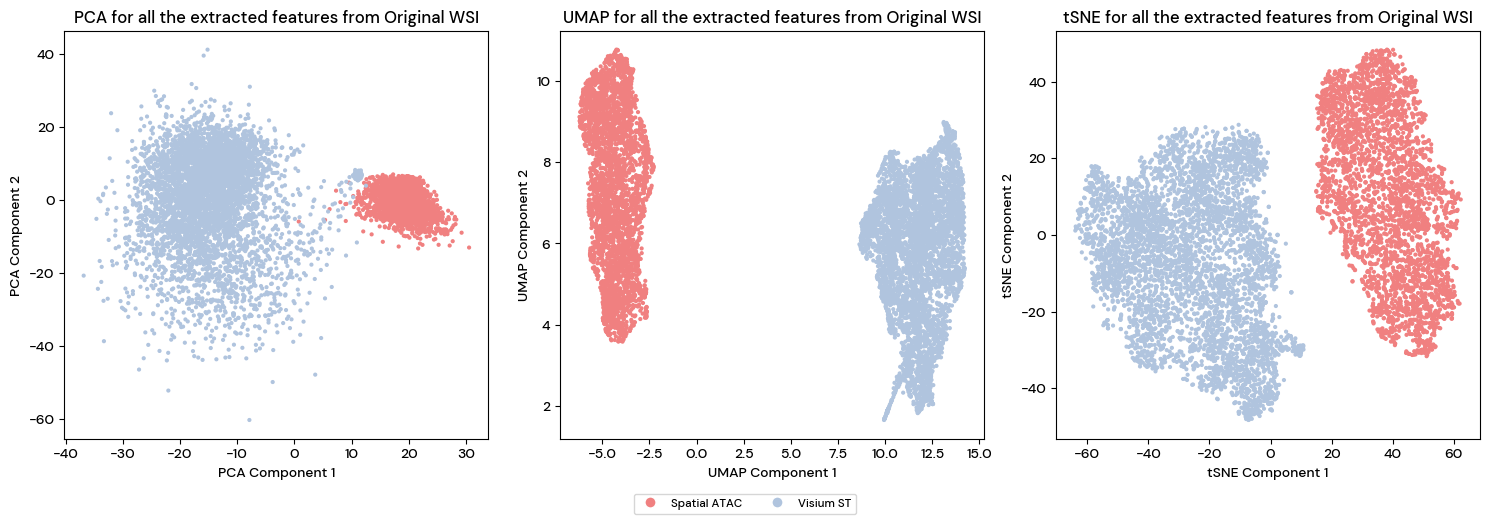

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import FeatureAgglomeration
from sklearn.decomposition import PCA#, TruncatedSVD
#import umap
import umap.umap_ as umap
from sklearn.manifold import TSNE
from matplotlib.lines import Line2D

# Initialize a figure to organize subplots for 18 plots (3 rows for PCA, UMAP, tSNE; 6 columns for cluster counts)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjusted size for better spacing
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Define a list of models and a dictionary for storing colors
models = [("PCA", PCA(n_components=2)), 
#          ("Truncated SVD", TruncatedSVD(n_components=2,  random_state=123)),
          ("UMAP", umap.UMAP(n_components=2, random_state=123)),
          ("tSNE", TSNE(n_components=2, perplexity=50, random_state=123))]

dim_red_results = {}

# Create a binary color mapping based on the presence of "-" in index names
index_names = merged_selected_pickle_df.index.astype(str)
color_labels = index_names.str.contains("-", regex=False).astype(int)  # 1 if "-" present, 0 otherwise

# Define colors for the two classes
color_map = {0: "lightcoral", 1: "lightsteelblue"}
colors = [color_map[label] for label in color_labels]

for i, (method_name, model) in enumerate(models):
    result = model.fit_transform(merged_selected_pickle_df)
    
    dim_red_results[method_name] = result

    # Plot the reduced result in a subplot
    ax = axes[i]  
    scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')

    ax.set_title(f"{method_name} for all the extracted features from {NORMALISATION_NAME}")
    ax.set_xlabel(f'{method_name} Component 1')
    ax.set_ylabel(f'{method_name} Component 2')

# Create legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label=label, 
                          markerfacecolor=color, markersize=8)
                   for label, color in [("Spatial ATAC", "lightcoral"), ("Visium ST", "lightsteelblue")]]

fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.05), 
           ncol=2, fontsize='small')

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import FeatureAgglomeration
from sklearn.decomposition import PCA#, TruncatedSVD
#import umap
import umap.umap_ as umap
from sklearn.manifold import TSNE
from matplotlib.lines import Line2D

def all_dim_red(merged_df, normalisation_method, colors_dict_satac_visium):
    '''
    Function for plotting PCA, UMAP and tSNE for the merged dataframes and color by spatial method.
    Params:
    - merged_df: Pandas.DataFrame, the merged DataFrame for the two spatial methods
    - normalisation_method: String, the merged DataFrame for the two spatial methods
    - colors_dict_satac_visium: Pandas.DataFrame, the merged DataFrame for the two spatial methods
    '''
    # Initialize a figure to organize subplots for 18 plots (3 rows for PCA, UMAP, tSNE; 6 columns for cluster counts)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjusted size for better spacing
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    # Define a list of models and a dictionary for storing colors
    models = [("PCA", PCA(n_components=2)), 
    #          ("Truncated SVD", TruncatedSVD(n_components=2,  random_state=123)),
            ("UMAP", umap.UMAP(n_components=2, random_state=123)),
            ("tSNE", TSNE(n_components=2, perplexity=50, random_state=123))]

    dim_red_results = {}

    # Create a binary color mapping based on the presence of "-" in index names
    index_names = merged_selected_pickle_df.index.astype(str)
    color_labels = index_names.str.contains("-", regex=False).astype(int)  # 1 if "-" present, 0 otherwise

    # Define colors for the two classes
    color_map = {0: "lightcoral", 1: "lightsteelblue"}
    colors = [color_map[label] for label in color_labels]

    for i, (method_name, model) in enumerate(models):
        # model transformation
        result = model.fit_transform(merged_selected_pickle_df)
        
        dim_red_results[method_name] = result

        # Plot the reduced result in a subplot
        ax = axes[i]  
        scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')

        ax.set_title(f"{method_name} for all the extracted features from {normalisation_method}")
        ax.set_xlabel(f'{method_name} Component 1')
        ax.set_ylabel(f'{method_name} Component 2')

    # Create legend
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=label, 
                            markerfacecolor=color, markersize=8)
                    for label, color in [("Spatial ATAC", "lightcoral"), ("Visium ST", "lightsteelblue")]]

    fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.05), 
            ncol=2, fontsize='small')

    plt.tight_layout()
    return plt.show()


## 3.2 Spectral Clustering

When we talk about “affinity”, we are essentially referring to how similar two points are to each other. In practical terms, affinity determines how close or similar points are in a multidimensional space. The more similar two points are, the greater the value of the affinity between them, and vice versa.

In the context of spectral clustering, there are several methods to calculate affinity. Some of the main methods are:

-   **Nearest Neighbors**: The affinity between points is calculated based on the Euclidean distance or a distance metric defined between the closest points.
-   **RBF (Radial Basis Function)**: Affinity is calculated using a Gaussian radial function, which measures the distance between points in feature space.
-   **Precomputed**: Allows you to provide a precomputed similarity or dissimilarity matrix between points.
-   **KNN (K-Nearest Neighbors)**: Uses the similarity between the k-nearest points as affinity.


# 4. Clustering

/disk2/user/gabgam/miniconda3/envs/kimianet_env/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/tmp/ipykernel_1599082/2483806383.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


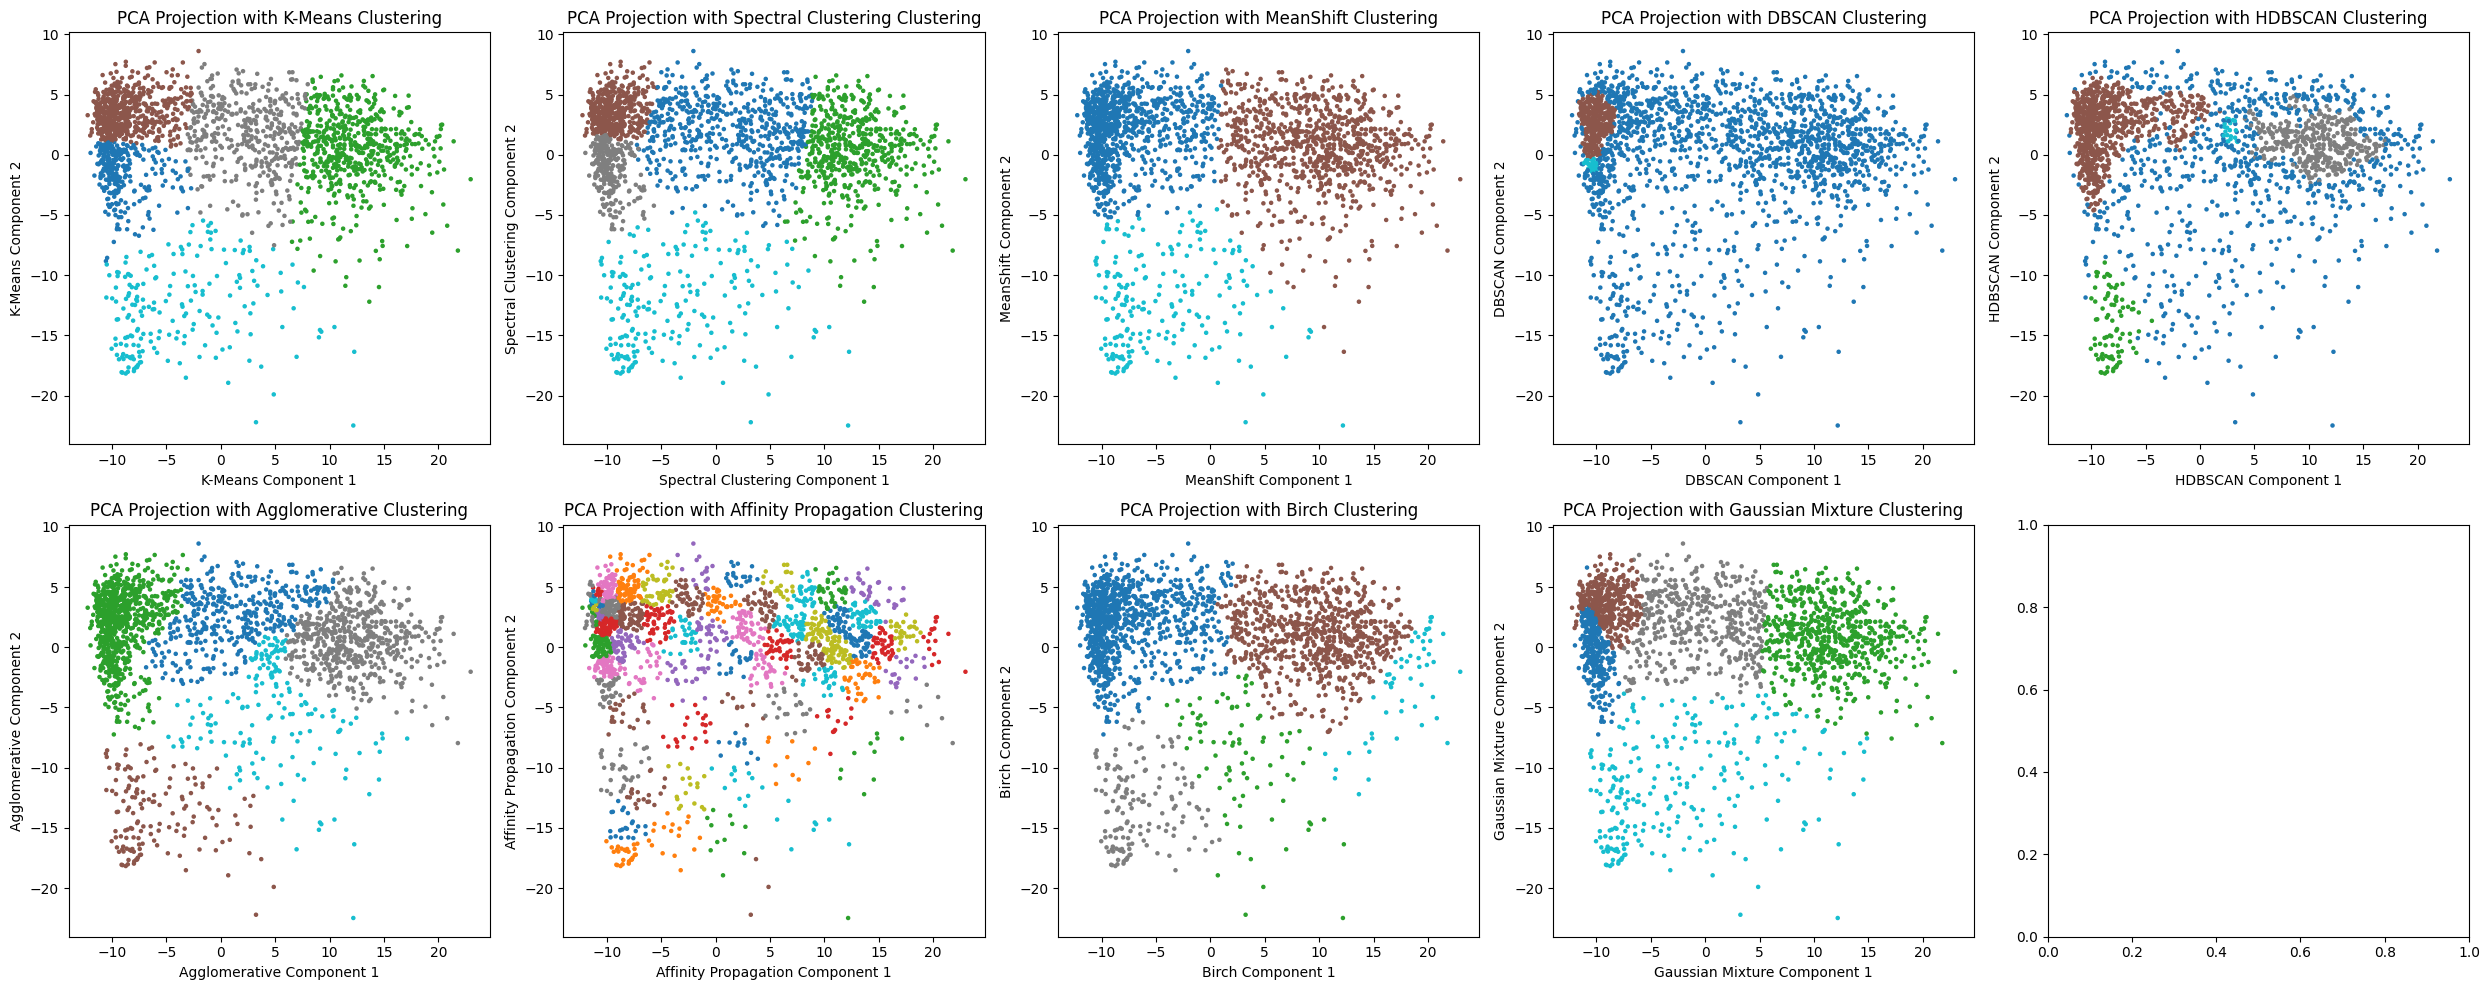

/disk2/user/gabgam/miniconda3/envs/kimianet_env/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/disk2/user/gabgam/miniconda3/envs/kimianet_env/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/tmp/ipykernel_1599082/2483806383.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


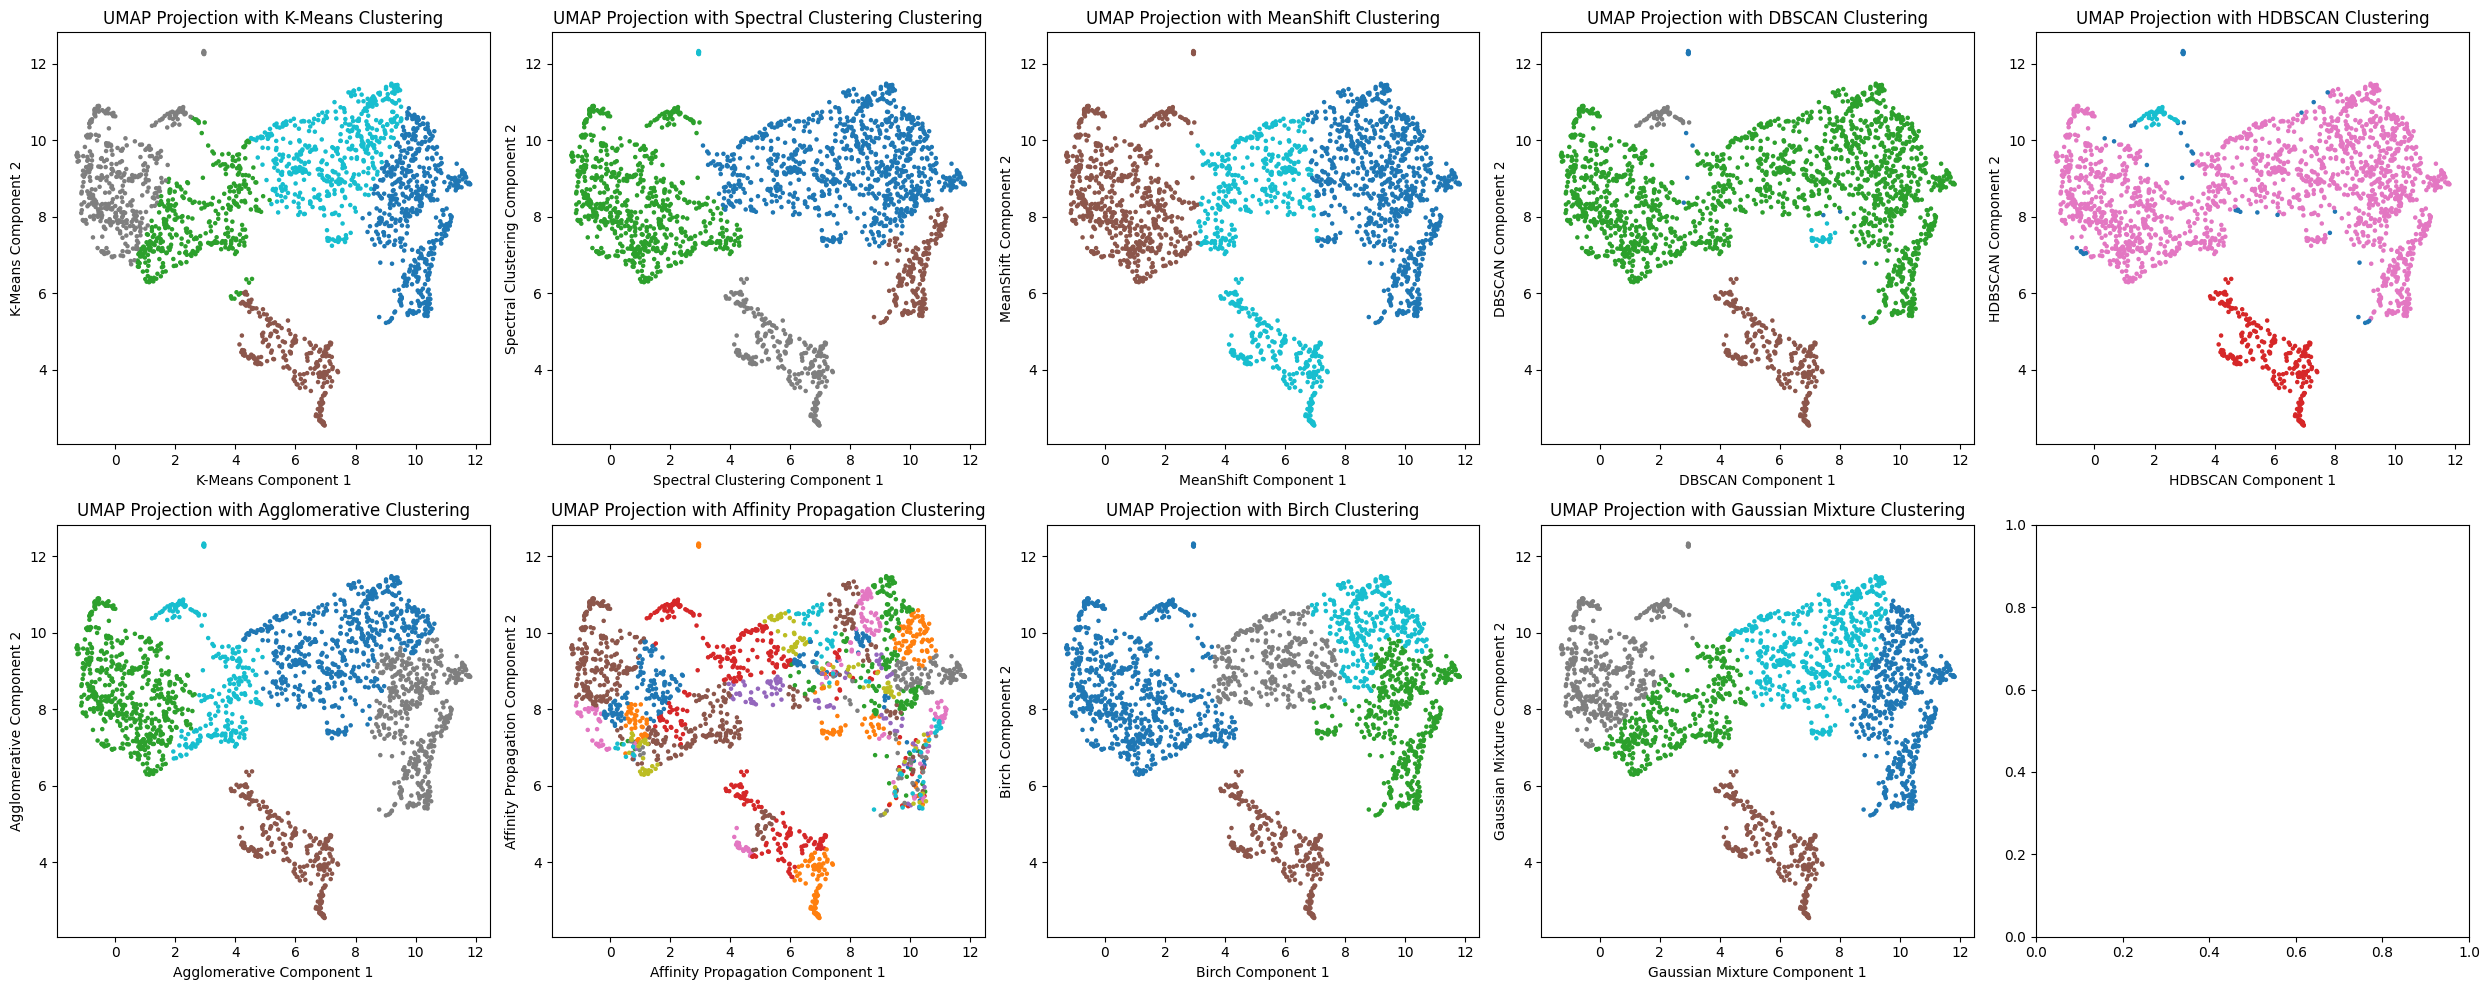

/disk2/user/gabgam/miniconda3/envs/kimianet_env/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/tmp/ipykernel_1599082/2483806383.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


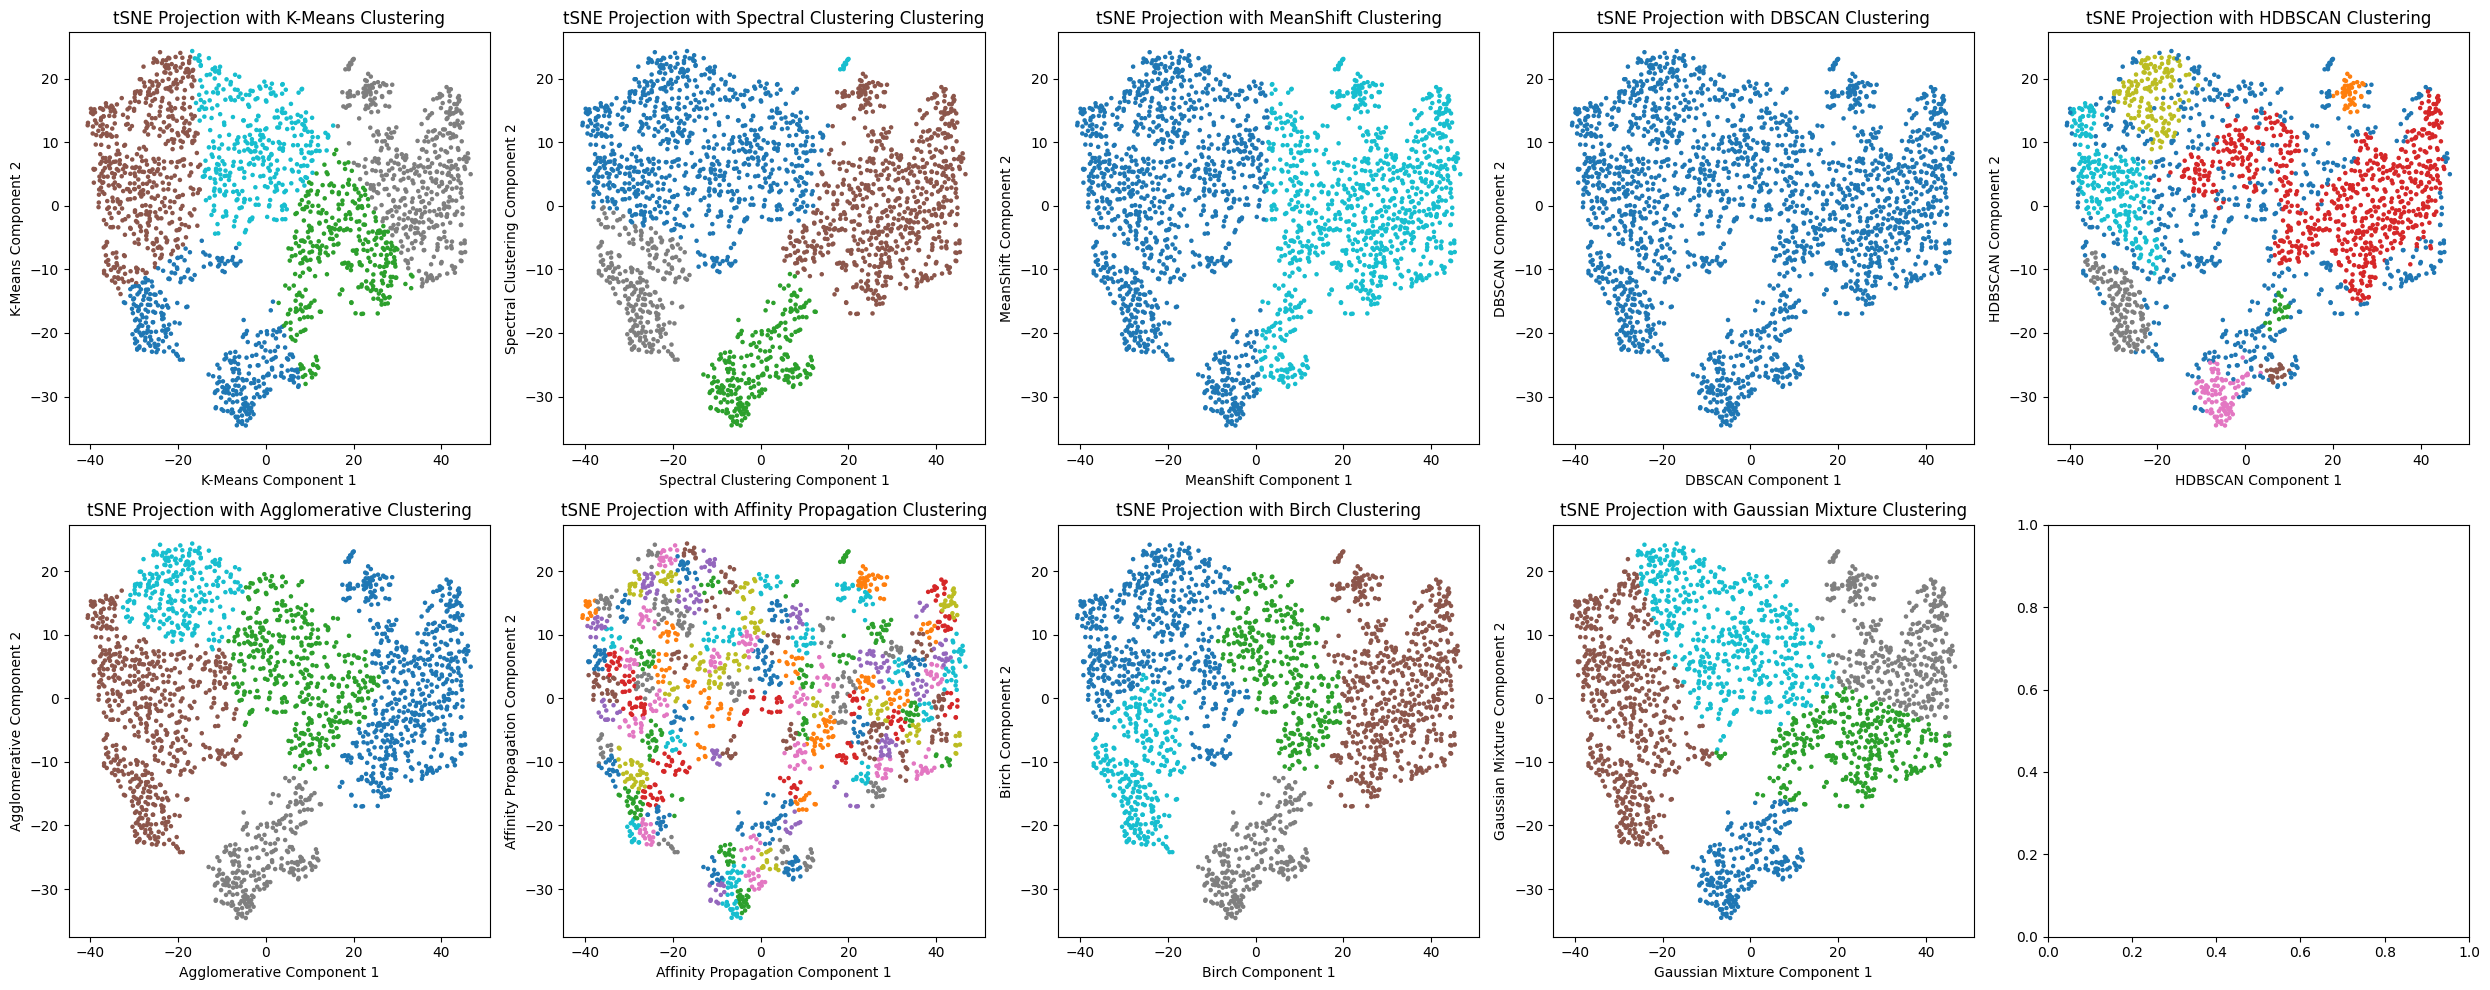

In [ ]:
import math
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, HDBSCAN, MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation, Birch
from sklearn.mixture import GaussianMixture


clustering_methods = [
    ("K-Means", KMeans(n_clusters=5, random_state=123)),
    ("Spectral Clustering", 
     (n_clusters=5, affinity='nearest_neighbors', n_neighbors=10, 
                                               eigen_solver='arpack', random_state=123)),
    ("MeanShift", MeanShift()),  # bandwidth will be estimated later
    ("DBSCAN", DBSCAN(eps=0.5, min_samples=20)),
    ("HDBSCAN", HDBSCAN(min_cluster_size=20)),
    ("Agglomerative", AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')),
    ("Affinity Propagation", AffinityPropagation(preference=-50)),  # Adjust preference as needed
    ("Birch", Birch(threshold=0.5, n_clusters=5)),  # Adjust threshold as needed
    ("Gaussian Mixture", GaussianMixture(n_components=5, random_state=123))
]

n_methods = len(clustering_methods)
rows = 2
cols = math.ceil(n_methods / rows)

for tech in dim_red_results.keys():
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5), constrained_layout=True)
    
    for i, (method_name, model) in enumerate(clustering_methods):
        # Estimate bandwidth if using MeanShift
        if method_name == "MeanShift":
            est_band = estimate_bandwidth(dim_red_results[tech])
            model.set_params(bandwidth=est_band)
        
        

        # Compute row and col indices
        row, col = divmod(i, cols)
        
        # Fit the clustering model and predict labels
        cluster_labels = model.fit_predict(dim_red_results[tech])
        
        # Plot in the appropriate subplot
        ax = axes[row, col]  # Access subplot by row and column
        scatter = ax.scatter(dim_red_results[tech][:, 0], dim_red_results[tech][:, 1], c=cluster_labels, s=5, cmap='tab10')
        ax.set_title(f"{tech} Projection with {method_name} Clustering")
        ax.set_xlabel(f'{method_name} Component 1')
        ax.set_ylabel(f'{method_name} Component 2')
    
    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.datasets import make_blobs

# Generate sample data
X, _ = make_blobs(n_samples=100, centers=3, cluster_std=0.60, random_state=0)

# Apply Spectral Clustering
sc = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', n_init=100)
labels = sc.fit_predict(X)

print("Cluster labels:", labels)